# Improving WW3 predction with Machine Learning

First, install the requirements:

```bash
# create a new environment
conda create --name tf python=3.7
# activate your new environment
conda activate tf

# install tensorflow CPU version
conda install tensorflow=2
conda install tensorboard

# If you have a NVIDIA GPU installed and properly configured
conda install tensorflow-gpu=2
conda install tensorboard

# Natsort - better file sorting
conda install natsort

# Data I/O
import xarray as xr

# Classical machine learning
conda install pandas scikit-learn scikit-image

# Matplotlib and seaborn
conda install matplotlib seaborn

# make your life easier with ipython
conda install ipython
```

# 4 - Comparison with newly acquired data

In this section, we use our pre-trained models to predict new data. Note that the model has never seen this data before.

## 4.1 Load packages

In [1]:
import os

import datetime

import pandas as pd

import numpy as np

import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

from joblib import load

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_context("paper", font_scale=1.25, rc={"lines.linewidth": 2.0})
sns.set_style("ticks", {"axes.linewidth": 2,
                        "legend.frameon": True,
                        "axes.facecolor": "#E9E9F1",
                        "grid.color": "w"})
mpl.rcParams["axes.linewidth"] = 2

## 4.2 - Load and scale data

### 4.2.1 - Integrated data

In [2]:
# load
int_data = pd.read_csv("Buoy_WaValp_wpar_v2.csv")  # these are the integrated data

# tanslate the direction to radians
int_data["Dm_mod_rad"] = np.deg2rad(int_data["Dm_mod"]) - np.pi
int_data["Dm_obs_rad"] = np.deg2rad(int_data["Dm_obs"]) - np.pi

# Compute the sin and cos of the direction.
# These are the target variables
# using the raw direction will cause the model not to learn
# anything beucause of the modular nature of directions.

int_data["Dm_mod_sinx"] = np.sin(int_data["Dm_mod_rad"])
int_data["Dm_mod_cosx"] = np.cos(int_data["Dm_mod_rad"])

int_data["Dm_obs_sinx"] = np.sin(int_data["Dm_obs_rad"])
int_data["Dm_obs_cosx"] = np.cos(int_data["Dm_obs_rad"])

scaler_int = load("INT_MLP_xscaler.dat")
train_features = ["Hm0_mod", "Tm1_mod", "Tm2_mod", "Spr_mod", "uwind_mod", "vwind_mod", "Dm_mod_sinx", "Dm_mod_cosx"]
X_int = scaler_int.transform(int_data[train_features].values)

### 4.2.2 - Spectral data

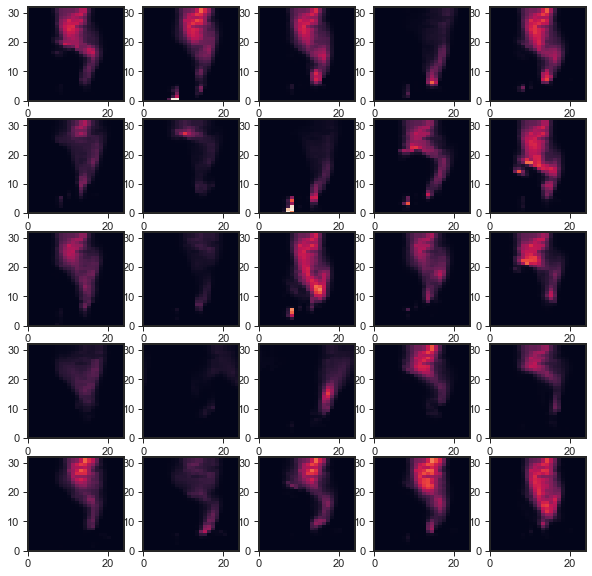

In [3]:
spc_data = pd.read_csv("Buoy_WaValp_spc_v2.csv", header=None)  # these are the spectral data

# get the spectrum
spc = spc_data.iloc[:, 1:769].values

# load the scaler
scaler_spc = load("SPC_MLP_xscaler.dat")
X_spc_mlp = scaler_spc.transform(spc)
X_spc_cnn = X_spc_mlp.reshape(X_spc_mlp.shape[0], 32, 24, 1)

# plot the first samples
fig, ax = plt.subplots(5, 5, figsize=(10,10))
axs = ax.flatten()
k = 0
for i in np.linspace(0, len(X_spc_cnn)-1, 5*5).astype(int):
    axs[k].pcolormesh(np.squeeze(X_spc_cnn[i, :, :, :]), vmin=0, vmax=1)
    k += 1

plt.show()

## 4.3 - Load the models

In [4]:
mlp_int = load_model("MLP.h5")
mlp_spc = load_model("SPC_MLP.h5")
cnn_spc = load_model("CNN.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 4.4 - Make predictions

In [5]:
y_pred_mlp_int = np.squeeze(mlp_int.predict(X_int))
y_pred_mlp_spc = np.squeeze(mlp_spc.predict(X_spc_mlp))
y_pred_cnn_spc = np.squeeze(cnn_spc.predict(X_spc_cnn))

In [6]:
# convert everything back to radians
y_pred_mlp_int_rad = np.arctan2(y_pred_mlp_int[:, 0], y_pred_mlp_int[:, 1])
y_pred_mlp_spc_rad = np.arctan2(y_pred_mlp_spc[:, 0], y_pred_mlp_spc[:, 1])
y_pred_cnn_spc_rad = np.arctan2(y_pred_cnn_spc[:, 0], y_pred_cnn_spc[:, 1])

In [7]:
# convert everything back to degrees
y_pred_mlp_int_deg = np.rad2deg(y_pred_mlp_int_rad + np.pi)
y_pred_mlp_spc_deg = np.rad2deg(y_pred_mlp_spc_rad + np.pi)
y_pred_cnn_spc_deg = np.rad2deg(y_pred_cnn_spc_rad + np.pi)

## 4.5 - Plot the predicted timeseries

In [14]:
ww3 = int_data["Dm_mod"].values
data = int_data["Dm_obs"].values
time = pd.to_datetime(int_data["Time_UTC"].values).to_pydatetime()

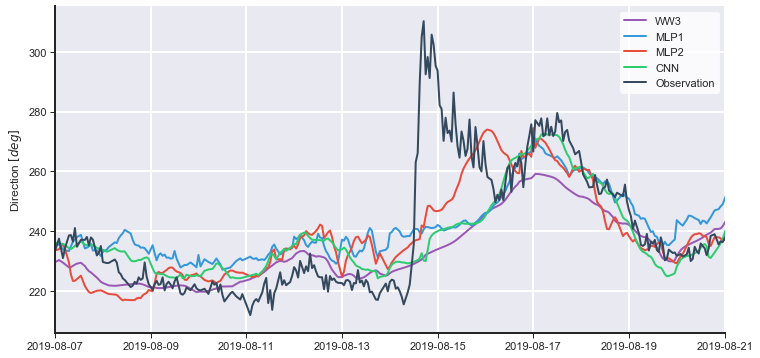

In [15]:
colors = ["#9b59b6", "#3498db", "#e74c3c", "#2ecc71", "#34495e"]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, ww3, color=colors[0], label="WW3")
ax.plot(time, y_pred_mlp_int_deg, color=colors[1], label="MLP1")
ax.plot(time, y_pred_mlp_spc_deg, color=colors[2], label="MLP2")
ax.plot(time, y_pred_cnn_spc_deg, color=colors[3], label="CNN")
ax.plot(time, data, color=colors[4], label="Observation")

ax.grid(color="w", ls="-", lw=2)

lg = ax.legend()
lg.get_frame().set_color("w")

sns.despine(ax=ax)

ax.set_xlim(datetime.datetime(2019, 8, 7),datetime.datetime(2019, 8, 21))
            

ax.set_ylabel(r"Direction $[deg]$")

plt.show()